In [21]:
import re
import numpy as np

def parse_model_results(text):
    """
    Parse model results text into nested dicts:
      parsed_info[model][alpha]['phase2'] is a dict of column names to numpy arrays
    Args:
      text (str): multiline text with sections like 'MLP; alpha=10' and tables
    Returns:
      dict: nested structure
    """
    parsed = {}
    # Split by model blocks: find lines like 'MLP; alpha=10' or 'CNN; alpha = 0'
    # Pattern: model name ; alpha = value
    block_pattern = re.compile(r"^(MLP|CNN);\s*alpha\s*=\s*([0-9]+)", re.MULTILINE)
    # Find all block headers with positions
    headers = [(m.group(1), int(m.group(2)), m.start()) for m in block_pattern.finditer(text)]
    # Append end of text as boundary
    boundaries = [pos for *_ , pos in headers] + [len(text)]
    # Process each block
    for i, (model, alpha, start) in enumerate(headers):
        end = boundaries[i+1]
        block_text = text[start:end]
        # Initialize dict
        parsed.setdefault(model, {})[alpha] = {}
        # Split into lines
        lines = [l for l in block_text.splitlines() if l.strip()]
        # Find header for stage2 columns
        # find index of 'stage2' header line (assume column names on same line?) Actually example: second line after phase header is data header but text uses table header row repeated per section.
        # Identify the header row by presence of 'phase' and 'epoch'
        header_row = None
        for line in lines:
            if line.strip().startswith('phase'):
                header_row = line
                break
        if header_row is None:
            continue
        cols = header_row.split()
        # Collect stage2 data
        data = []
        for line in lines:
            if line.strip().startswith('stage2'):
                parts = line.split()
                # parts[0]=stage2, parts[1]=epoch, rest correspond to cols[2:]
                epoch = int(parts[1])
                values = [float(x) if x!='NaN' else np.nan for x in parts[2:]]
                data.append(values)
        if data:
            arr = np.array(data)  # shape (n_epochs, n_columns-2)
            # map each column to its array
            for j, col in enumerate(cols[2:]):
                parsed[model][alpha][col] = arr[:, j]
    return parsed

def parse_phase2_steps(text):
    """
    Parse phase 2 step-level metrics into a flat dict of numpy arrays.
    Only lines matching Stage2 steps with EN and FR metrics are captured.

    Returns:
      dict: {
        'steps': np.array([...]),
        'en_val_acc': np.array([...]),
        'en_val_loss': np.array([...]),
        'fr_val_acc': np.array([...]),
        'fr_val_loss': np.array([...]),
      }
    """
    pattern = re.compile(
        r"\[Stage2-[^\]]+\]\[Epoch\s*\d+\]\[Step\s*(\d+)\]"
        r"\s*EN val-acc:\s*([0-9\.]+), val-loss:\s*([0-9\.]+)"
        r"\s*\| FR val-acc:\s*([0-9\.]+), val-loss:\s*([0-9\.]+)"
    )
    steps, en_acc, en_loss, fr_acc, fr_loss = [], [], [], [], []
    for line in text.splitlines():
        m = pattern.search(line)
        if m:
            steps.append(int(m.group(1)))
            en_acc.append(float(m.group(2)))
            en_loss.append(float(m.group(3)))
            fr_acc.append(float(m.group(4)))
            fr_loss.append(float(m.group(5)))
    if not steps:
        return {}
    return {
        'steps': np.array(steps),
        'en_val_acc': np.array(en_acc),
        'en_val_loss': np.array(en_loss),
        'fr_val_acc': np.array(fr_acc),
        'fr_val_loss': np.array(fr_loss),
    }


# Example usage:
# text = open('results.txt').read()
# info = parse_model_results(text)
# print(info['CNN'][0]['loss_0_4'])  # numpy array of stage2 losses for acc_0_4


In [4]:
results = """

MLP; alpha=10

 phase  epoch  acc_0_4  loss_0_4  acc_5_9  loss_5_9
stage1      1 0.930142  0.556255      NaN       NaN
stage1      2 0.946488  0.306153      NaN       NaN
stage1      3 0.954077  0.230820      NaN       NaN
stage2      1 0.319712  1.969013 0.862168  0.804050
stage2      2 0.104884  2.936034 0.895906  0.518444
stage2      3 0.057404  3.551050 0.906604  0.411021
stage2      4 0.033275  3.992003 0.913187  0.355768
stage2      5 0.021405  4.321050 0.916478  0.321716
stage2      6 0.011870  4.590000 0.921004  0.298660
stage2      7 0.005254  4.809794 0.924707  0.281774
stage2      8 0.001557  4.994639 0.926970  0.268837
stage2      9 0.000389  5.152673 0.929233  0.258557
stage2     10 0.000389  5.292533 0.930467  0.250099
stage2     11 0.000195  5.421034 0.932113  0.242859
stage2     12 0.000000  5.528269 0.932524  0.236746
stage2     13 0.000000  5.629037 0.933141  0.231310
stage2     14 0.000000  5.718009 0.934376  0.226504
stage2     15 0.000000  5.791902 0.935199  0.222282
stage2     16 0.000000  5.870452 0.935199  0.218549
stage2     17 0.000000  5.939659 0.936639  0.215078
stage2     18 0.000000  6.005109 0.936639  0.211779
stage2     19 0.000000  6.066436 0.937256  0.208913
stage2     20 0.000000  6.116763 0.938490  0.206176
stage2     21 0.000000  6.167451 0.938901  0.203496
stage2     22 0.000000  6.219561 0.939519  0.201069
stage2     23 0.000000  6.259289 0.939724  0.198803
stage2     24 0.000000  6.304103 0.940753  0.196723
stage2     25 0.000000  6.342760 0.940959  0.194700
stage2     26 0.000000  6.381167 0.941164  0.192688
stage2     27 0.000000  6.419921 0.941576  0.190973
stage2     28 0.000000  6.451553 0.943222  0.189214
stage2     29 0.000000  6.483952 0.942604  0.187617
stage2     30 0.000000  6.514506 0.943222  0.185909
stage2     31 0.000000  6.543838 0.942604  0.184367
stage2     32 0.000000  6.574366 0.943427  0.182835
stage2     33 0.000000  6.601158 0.944044  0.181395
stage2     34 0.000000  6.637342 0.944250  0.180039
stage2     35 0.000000  6.657896 0.946307  0.178669
stage2     36 0.000000  6.687705 0.946925  0.177348
stage2     37 0.000000  6.709809 0.947130  0.176093
stage2     38 0.000000  6.736544 0.947542  0.174928
stage2     39 0.000000  6.755447 0.948570  0.173688
stage2     40 0.000000  6.783935 0.947953  0.172567
stage2     41 0.000000  6.806020 0.948159  0.171470
stage2     42 0.000000  6.819824 0.948776  0.170345
stage2     43 0.000000  6.841650 0.949805  0.169277
stage2     44 0.000000  6.858235 0.949599  0.168300
stage2     45 0.000000  6.884618 0.950010  0.167284

MLP; alpha = 0

 phase  epoch  acc_0_4  loss_0_4  acc_5_9  loss_5_9
stage1      1 0.924304  0.538324      NaN       NaN
stage1      2 0.944347  0.288243      NaN       NaN
stage1      3 0.951352  0.216704      NaN       NaN
stage2      1 0.196731  2.334129 0.872660  0.697351
stage2      2 0.052150  3.466369 0.895906  0.452124
stage2      3 0.020043  4.156191 0.908044  0.363618
stage2      4 0.009146  4.648490 0.915449  0.318060
stage2      5 0.004086  5.009211 0.920387  0.290468
stage2      6 0.000973  5.279959 0.922238  0.271471
stage2      7 0.000778  5.509835 0.925118  0.257631
stage2      8 0.000389  5.709157 0.928616  0.246761
stage2      9 0.000389  5.866322 0.930261  0.238079
stage2     10 0.000195  5.993139 0.931907  0.230848
stage2     11 0.000195  6.127966 0.933347  0.224557
stage2     12 0.000195  6.225224 0.934581  0.219038
stage2     13 0.000195  6.322337 0.936433  0.214099
stage2     14 0.000195  6.429629 0.937050  0.210055
stage2     15 0.000195  6.507995 0.937461  0.206063
stage2     16 0.000195  6.564191 0.937873  0.202419
stage2     17 0.000195  6.627515 0.938901  0.199131
stage2     18 0.000000  6.679501 0.938901  0.195952
stage2     19 0.000000  6.730259 0.940136  0.192959
stage2     20 0.000000  6.781282 0.940547  0.190047
stage2     21 0.000000  6.841455 0.940341  0.187486
stage2     22 0.000000  6.879464 0.941987  0.184926
stage2     23 0.000000  6.932416 0.942193  0.182619
stage2     24 0.000000  6.968570 0.942810  0.180045
stage2     25 0.000000  7.014787 0.943427  0.178117
stage2     26 0.000000  7.030678 0.944456  0.175644
stage2     27 0.000000  7.085066 0.945279  0.173732
stage2     28 0.000000  7.096908 0.946513  0.171511
stage2     29 0.000000  7.132682 0.947542  0.169306
stage2     30 0.000000  7.149093 0.947542  0.167392
stage2     31 0.000000  7.168160 0.947953  0.165464
stage2     32 0.000000  7.199273 0.948159  0.163806
stage2     33 0.000000  7.223163 0.949599  0.161844
stage2     34 0.000000  7.251143 0.949393  0.160135
stage2     35 0.000000  7.260613 0.950627  0.158164

CNN; alpha=0
 phase  epoch  acc_0_4  loss_0_4  acc_5_9  loss_5_9
stage1      1 0.950574  0.284372      NaN       NaN
stage2      1 0.000000  4.604070 0.904341  0.368741
stage2      2 0.000000  5.948188 0.919770  0.264265
stage2      3 0.000000  6.926626 0.933141  0.224664
stage2      4 0.000000  7.550047 0.937256  0.200046
stage2      5 0.000000  8.015697 0.945484  0.179910
stage2      6 0.000000  8.518880 0.948776  0.165357
stage2      7 0.000000  8.994730 0.952890  0.153420

CNN; alpha = 100
 phase  epoch  acc_0_4  loss_0_4  acc_5_9  loss_5_9
stage1      1 0.943374  0.401059      NaN       NaN
stage1      2 0.957190  0.199362      NaN       NaN
stage2      1 0.081533  3.076460 0.882740  0.541437
stage2      2 0.038334  3.827482 0.903312  0.373957
stage2      3 0.023935  4.231500 0.911335  0.313282
stage2      4 0.016346  4.459603 0.920387  0.281206
stage2      5 0.009146  4.722988 0.923473  0.260337
stage2      6 0.007589  4.871692 0.927793  0.244988
stage2      7 0.004670  5.018585 0.930056  0.233338
stage2      8 0.003503  5.172822 0.932113  0.224546
stage2      9 0.003503  5.173538 0.932730  0.217282
stage2     10 0.002919  5.260224 0.934581  0.210682
stage2     11 0.001362  5.360486 0.936639  0.204332
stage2     12 0.001168  5.403756 0.938079  0.199510
stage2     13 0.001168  5.468258 0.939519  0.194458
stage2     14 0.000973  5.482537 0.941164  0.190311
stage2     15 0.000584  5.538519 0.941370  0.186669
stage2     16 0.000389  5.606562 0.942399  0.183146
stage2     17 0.000195  5.637720 0.942399  0.179447
stage2     18 0.000195  5.690634 0.944456  0.176541
stage2     19 0.000195  5.733494 0.945690  0.173717
stage2     20 0.000195  5.775521 0.945896  0.171233
stage2     21 0.000000  5.833005 0.947130  0.168927
stage2     22 0.000000  5.857893 0.947953  0.166725
stage2     23 0.000000  5.880108 0.948776  0.164579
stage2     24 0.000000  5.895675 0.948982  0.162748
stage2     25 0.000000  5.906987 0.950010  0.161034


"""

In [5]:
info = parse_model_results(results)

In [7]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'MNIST RESULTS')

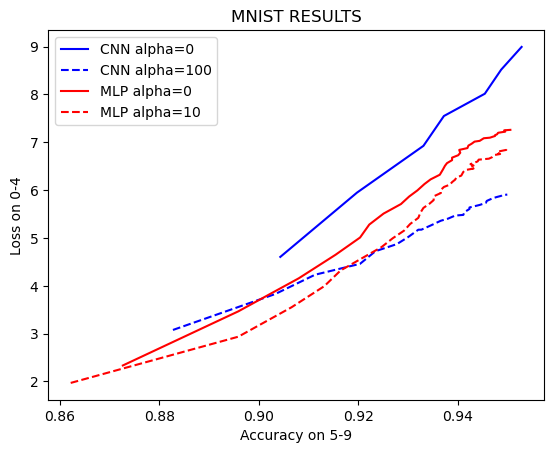

In [16]:
plt.plot(info['CNN'][0]['acc_5_9'],info['CNN'][0]['loss_0_4'], 'b' ,label='CNN alpha=0')
plt.plot(info['CNN'][100]['acc_5_9'],info['CNN'][100]['loss_0_4'], '--b' , label='CNN alpha=100')
plt.plot(info['MLP'][0]['acc_5_9'],info['MLP'][0]['loss_0_4'],'r', label='MLP alpha=0')
plt.plot(info['MLP'][10]['acc_5_9'],info['MLP'][10]['loss_0_4'],'--r', label='MLP alpha=10')
plt.legend()
plt.xlabel('Accuracy on 5-9')
plt.ylabel('Loss on 0-4')
plt.title('MNIST RESULTS')

In [25]:
text10 = open('/homes/ar2342/one_more_dir/contextual_frogs/experimental/lm_benchmarker_alpha10_5.log').read()
text0 = open('/homes/ar2342/one_more_dir/contextual_frogs/experimental/lm_benchmarker_alpha0_1.log').read()

In [26]:
infolm10 = parse_phase2_steps(text10)
infolm0 = parse_phase2_steps(text0)

Text(0.5, 1.0, 'LM RESULTS')

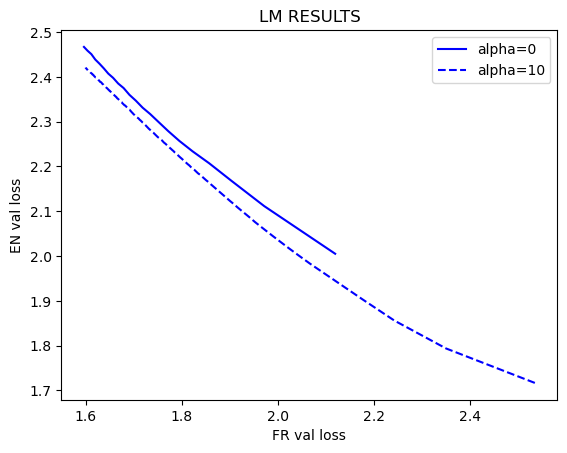

In [29]:
plt.plot(infolm0['fr_val_loss'],infolm0['en_val_loss'], 'b' ,label='alpha=0')
plt.plot(infolm10['fr_val_loss'],infolm10['en_val_loss'], 'b--' ,label='alpha=10')
plt.legend()
xlabel = 'FR val loss'
plt.xlabel(xlabel)
plt.ylabel('EN val loss')
plt.title('LM RESULTS')
# plt.plot(infolm['steps'],infolm['fr_val_acc'], '--b' , label='FR val acc')